In [1]:
import pandas as pd
import numpy as np

Parameters for the Analysis

In [2]:
analysis_years = np.arange(1997, 2015, 1) # 2015 data does not have International Sunspot Number, so excluding it

noaa_filenames =[]
noaa_DSD_filenames=[]
for analysis_year in analysis_years: 
    noaa_filenames.append(str(analysis_year) + '.txt') 
    noaa_DSD_filenames.append(str(analysis_year) + '_DSD.txt')

year_prefix = '200' # need to adjust based in the year for 2003 it is 200, for 2010 it is 20, for 1996 it is 19.

Read in SOHO-LASCO CME Catalog (All Available Years)

In [3]:
# Import Catalog of Coronal Mass Ejection Data
# Data is in fixed width file format
data_file = 'SOHO-LASCO_CME_Catelog_univ_all.txt'
colspecs = [(0,10), (12,20), (24,27), (32,34), (37,41), (45,49), (52,56), (59,63), (66,72), (72,73), (76,83), (83,84), (87,94), (94,95), (98,101), (104, 147)]
names = ['Date', 'Time', 'CentralPA', 'Width', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'AFlag', 'Mass', 'MFlag', 'KineticEnergy', 'KEFlag', 'MPA',
'Remarks']
cme = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=4)
# Create the index as a datetime
cme.index = pd.to_datetime(cme.Date)

#cme.convert_objects(convert_numeric=True).dtypes # some columns can be converted 
cols_to_convert_to_float64 = ['CentralPA', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'Mass', 'KineticEnergy']
for col in cols_to_convert_to_float64:
    cme[col] = pd.to_numeric(cme[col], errors='coerce')

cme = cme[(cme.index.year >= analysis_years[0]) & (cme.index.year <= analysis_years[len(analysis_years) - 1])]
cme.shape

(24648, 16)

Create a series to analyze Linear Speed.  Create 1 entry per date with max of LinearSpeed

In [4]:
linear_max = cme.groupby([cme.index])['LinearSpeed'].max()
#linear_max = linear_max[(linear_max.index.year==analysis_year)]


Create a series to analyze 20R - the speed at 20 Solar Radii.  Create 1 entry per date using the max of 20R

In [5]:
c20R_max = cme.groupby([cme.index])['20R'].max()
#c20R_max = c20R_max[(c20R_max.index.year==analysis_year)]

Create a series that is the count of the cme's on a particular date

In [6]:
cme_count = cme.groupby([cme.index])['Date'].count()

Read in NOAA files of Geomagnetic data

In [7]:

colspecs = [(0,2), (2,4), (4,6), (6,10), (10,12), (12,14), (14,16), (16,18), (18,20), (20,22), (22,24), (24,26), (26,28), (28,30), 
            (58,60), (61, 62), (62,65)]
names = ['Year', 'Month', 'Day', 'Bartels', 'BDay', 'Kp0', 'Kp3', 'Kp6', 'Kp9', 'Kp12', 'Kp15', 'Kp18', 'Kp21', 'KpSum', 'Cp',
'C9', 'ISN']

first_file = True

for data_file in noaa_filenames:
    if first_file:
        noaa = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)
        first_file = False
    else:
        noaa_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)
        noaa = pd.concat([noaa, noaa_file])


In [8]:
noaa.loc[noaa['Year']>=95,['Year']] = 1900 + noaa.loc[noaa['Year']>=95,['Year']]
noaa.loc[noaa['Year']<=15,['Year']] = 2000 + noaa.loc[noaa['Year']<=15,['Year']]

# Create datetime index using the individual columns for Year, Month and Day
str_date =  noaa.Year.astype(str) + '/' + noaa.Month.astype(str) + '/' + noaa.Day.astype(str)
noaa['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa.index = noaa.Date
noaa['ISN'] = pd.to_numeric(noaa['ISN'], errors='coerce')

In [9]:
noaa.tail()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,Kp15,Kp18,Kp21,KpSum,Cp,C9,ISN,Date
Date,,,,,,,,,,,,,,,,,,
2014-12-27,2014,12,27,2474,27,33,20,13,17,17,10,3,3,11.0,0.0,1,62,2014-12-27
2014-12-28,2014,12,28,2475,1,23,20,13,13,13,17,37,23,16.0,0.0,2,68,2014-12-28
2014-12-29,2014,12,29,2475,2,20,30,23,33,37,47,33,47,27.0,1.0,5,64,2014-12-29
2014-12-30,2014,12,30,2475,3,30,40,37,20,30,27,27,23,23.0,0.0,4,66,2014-12-30
2014-12-31,2014,12,31,2475,4,13,23,13,17,20,33,13,17,15.0,0.0,2,65,2014-12-31


In [10]:
# Time shifting the C9 data in 1 day increments for 5 days so that we can compare solar activity to future space weather on Earth
C9 = noaa.C9
for n in range(5,-6,-1):
        shifted_forward =  C9.shift(n)  
        if n > 0:
                rsuffix =  str(-n)
        elif n < 0:
                rsuffix = '+' + str(-n)
        else:
                rsuffix = '_0'
                
        noaa = noaa.join(shifted_forward, rsuffix=rsuffix)
 
noaa.tail()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,...,C9-4,C9-3,C9-2,C9-1,C9_0,C9+1,C9+2,C9+3,C9+4,C9+5
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-27,2014,12,27,2474,27,33,20,13,17,17,...,3.0,4.0,3.0,4.0,1,2.0,5.0,4.0,2.0,NaN
2014-12-28,2014,12,28,2475,1,23,20,13,13,13,...,4.0,3.0,4.0,1.0,2,5.0,4.0,2.0,NaN,NaN
2014-12-29,2014,12,29,2475,2,20,30,23,33,37,...,3.0,4.0,1.0,2.0,5,4.0,2.0,NaN,NaN,NaN
2014-12-30,2014,12,30,2475,3,30,40,37,20,30,...,4.0,1.0,2.0,5.0,4,2.0,NaN,NaN,NaN,NaN
2014-12-31,2014,12,31,2475,4,13,23,13,17,20,...,1.0,2.0,5.0,4.0,2,NaN,NaN,NaN,NaN,NaN


Join the two dataframes together matching the cme data to the noaa data

In [11]:

colspecs = [(0,4), (5,7), (8,10), (12,16), (19,23), (27,32), (36,39), (49,54), (55,57), (58,60), (61,63), (64,66), (68,70), (71,73), 
            (74,76)]
names = ['Year', 'Month', 'Day', 'RadioFlux', 'SESC_SSN', 'SS_AREA', 'NEW_REGIONS', 'XrayBgndFlux', 'C', 'M', 'X', 'S', 'Opt1', 'Opt2', 'Opt3']

first_file = True

for data_file in noaa_DSD_filenames:
    if first_file:
        noaa_DSD = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        first_file = False
    else:
        noaa_DSD_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        noaa_DSD = pd.concat([noaa_DSD, noaa_DSD_file])

# Create datetime index using the individual columns for Year, Month and Day
str_date = noaa_DSD.Year.astype(str) + '/' + noaa_DSD.Month.astype(str) + '/' + noaa_DSD.Day.astype(str)
noaa_DSD.to_csv('../data/noaa_DSD.csv')
str_date
noaa_DSD['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa_DSD.index = noaa_DSD.Date
noaa_DSD.drop(['Year', 'Month', 'Day', 'Date'], axis=1, inplace=True)



In [12]:
result = pd.concat([ noaa, noaa_DSD, linear_max, c20R_max, cme_count], axis=1)
new_columns = result.columns.values
new_columns[len(new_columns)-3] = 'LinearSpeed_max'
new_columns[len(new_columns)-2] = '20R_max'
new_columns[len(new_columns)-1] = 'CME_daily_count'
result.columns = new_columns

result.shape

(6574, 44)

Set NaN values for LinearSpeed_max, 20R_max, and CME_daily_count to 0 indicated there were no recorded CME's on that date.

In [13]:
result.loc[result.LinearSpeed_max.isnull(), ['LinearSpeed_max']]=0
result.loc[result['20R_max'].isnull(), ['20R_max']]=0
result.loc[result.CME_daily_count.isnull(), ['CME_daily_count']]=0


In [14]:
%matplotlib inline

Ideas for plots:

1) X = date, Y = Linear Speed

2) X = date, Y = C9

In [15]:
result.drop('Date', axis=1, inplace=True)

In [16]:
result.reset_index().columns

Index([u'Date', u'Year', u'Month', u'Day', u'Bartels', u'BDay', u'Kp0', u'Kp3',
       u'Kp6', u'Kp9', u'Kp12', u'Kp15', u'Kp18', u'Kp21', u'KpSum', u'Cp',
       u'C9', u'ISN', u'C9-5', u'C9-4', u'C9-3', u'C9-2', u'C9-1', u'C9_0',
       u'C9+1', u'C9+2', u'C9+3', u'C9+4', u'C9+5', u'RadioFlux', u'SESC_SSN',
       u'SS_AREA', u'NEW_REGIONS', u'XrayBgndFlux', u'C', u'M', u'X', u'S',
       u'Opt1', u'Opt2', u'Opt3', u'LinearSpeed_max', u'20R_max',
       u'CME_daily_count'],
      dtype='object')

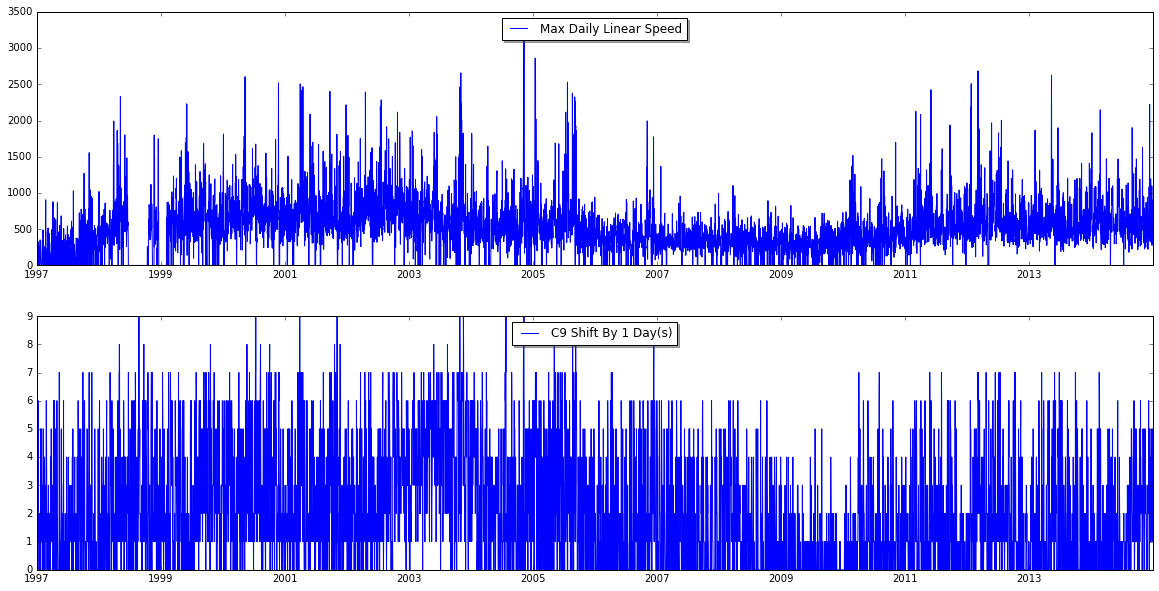

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.LinearSpeed_max, Label='Max Daily Linear Speed')
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.subplot(212)
plt.plot(result.index, result['C9+1'], Label='C9 Shift By 1 Day(s)')
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.show()

In [18]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1997-01-01 to 2014-12-31
Freq: D
Data columns (total 43 columns):
Year               6574 non-null int64
Month              6574 non-null int64
Day                6574 non-null int64
Bartels            6574 non-null int64
BDay               6574 non-null int64
Kp0                6574 non-null int64
Kp3                6574 non-null int64
Kp6                6574 non-null int64
Kp9                6574 non-null int64
Kp12               6574 non-null int64
Kp15               6574 non-null int64
Kp18               6574 non-null int64
Kp21               6574 non-null int64
KpSum              6559 non-null float64
Cp                 6574 non-null float64
C9                 6574 non-null int64
ISN                6574 non-null int64
C9-5               6569 non-null float64
C9-4               6570 non-null float64
C9-3               6571 non-null float64
C9-2               6572 non-null float64
C9-1               6573 non-null flo

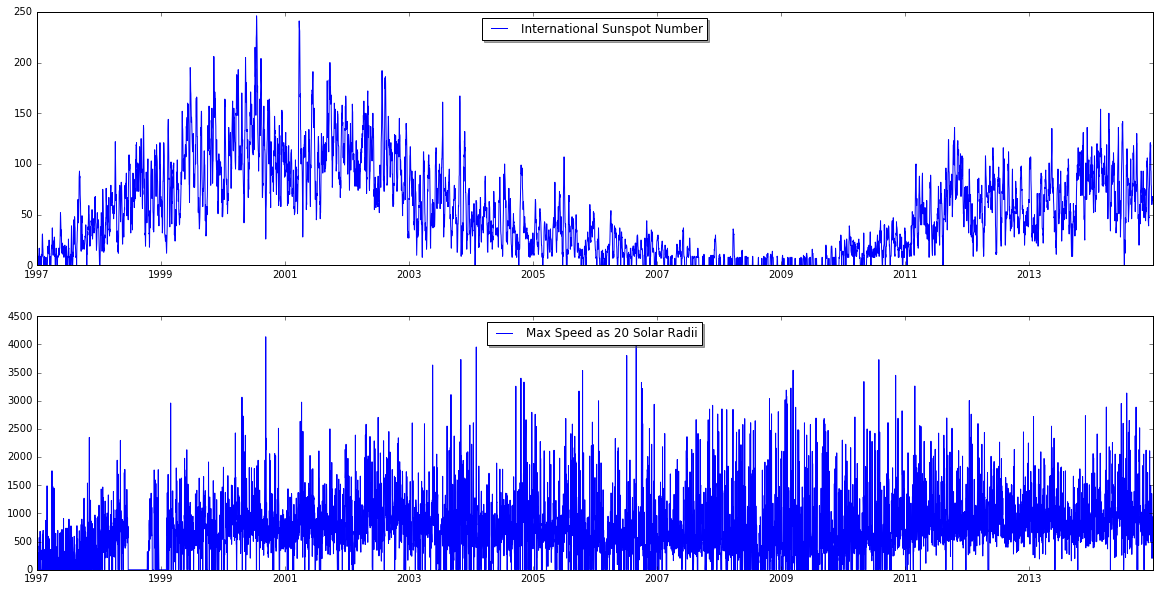

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['ISN'], Label="International Sunspot Number")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.subplot(212)
plt.plot(result.index, result['20R_max'], Label="Max Speed as 20 Solar Radii")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.show()

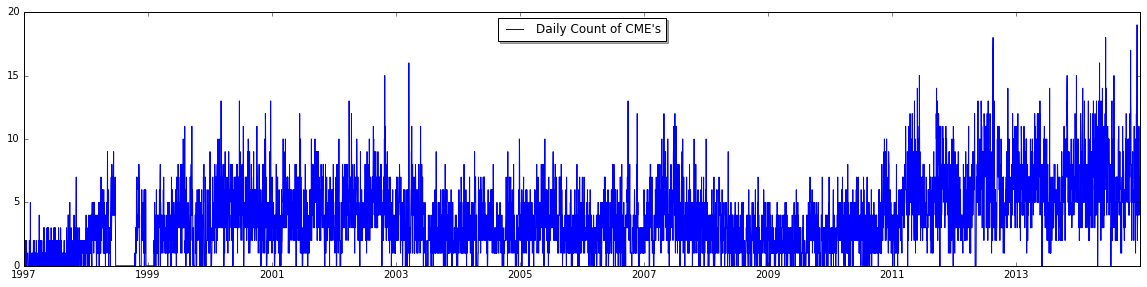

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['CME_daily_count'], Label="Daily Count of CME's")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')



plt.show()

feature_cols = ['LinearSpeed_max']
X = result[feature_cols]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

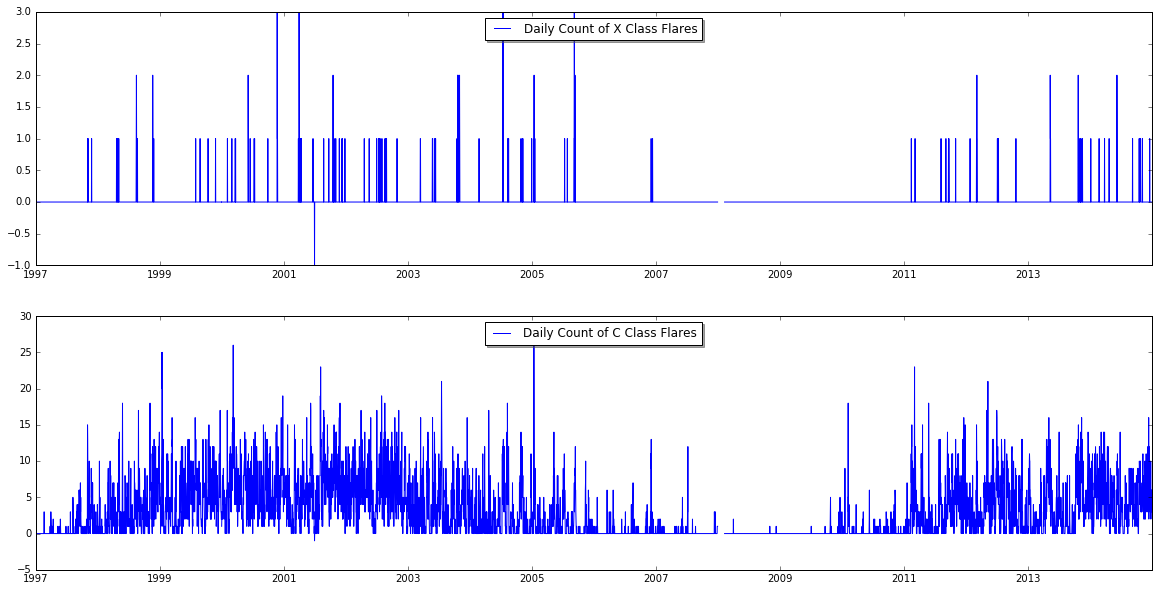

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['X'], Label="Daily Count of X Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.subplot(212)
plt.plot(result.index, result['C'], Label="Daily Count of C Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.show()

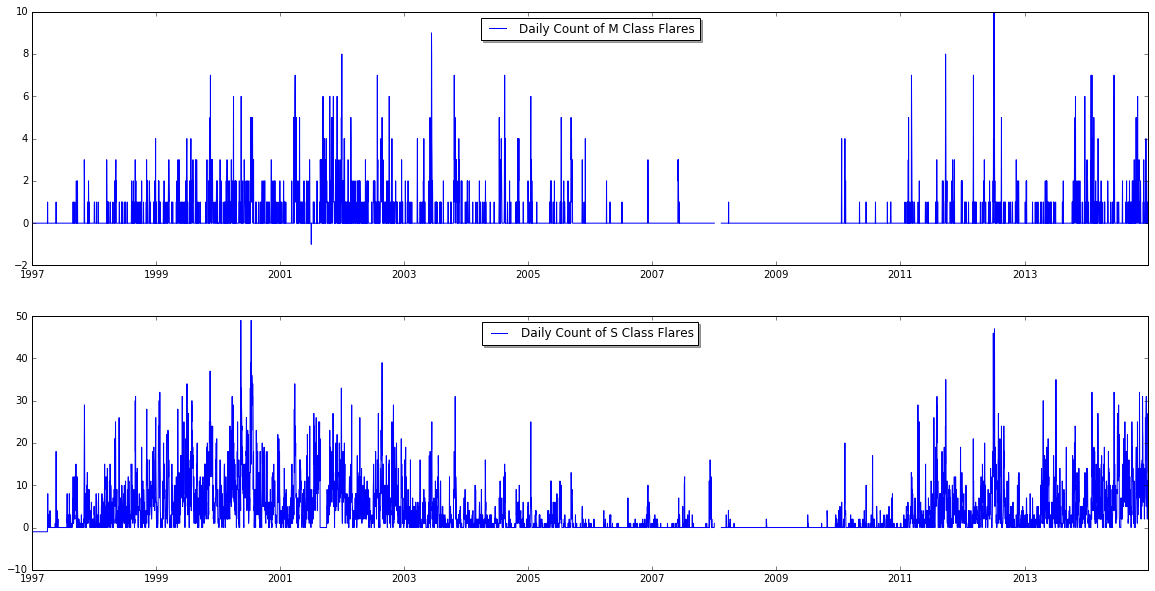

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['M'], Label="Daily Count of M Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.subplot(212)
plt.plot(result.index, result['S'], Label="Daily Count of S Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.show()

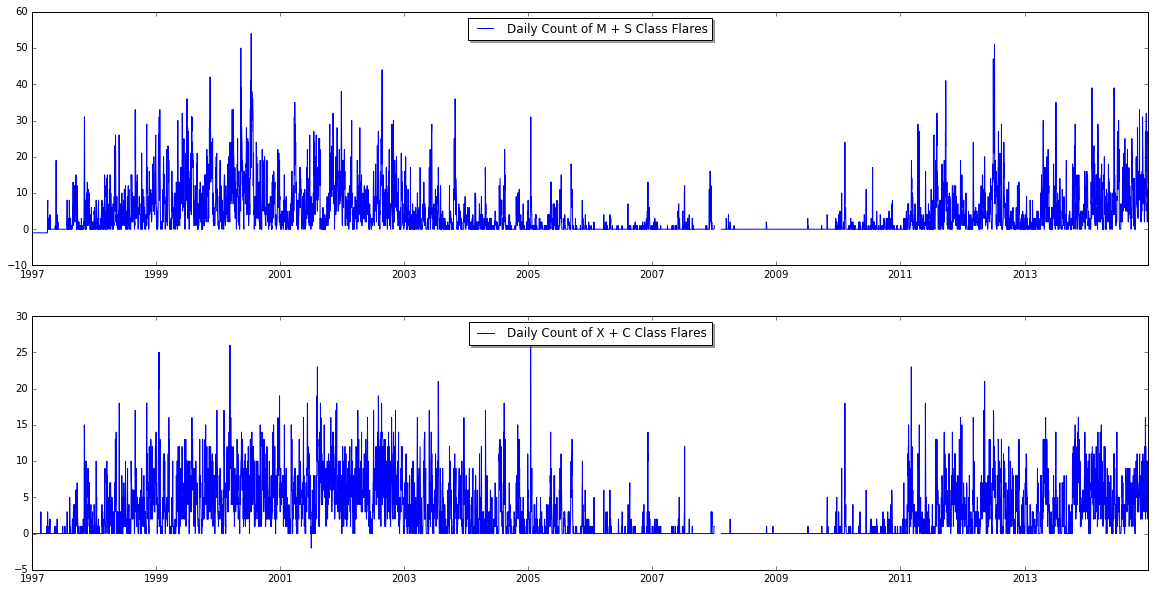

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.M + result.S, Label="Daily Count of M + S Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.subplot(212)
plt.plot(result.index, result.X + result.C, Label="Daily Count of X + C Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.show()

In [24]:
result['y']=np.where(result['C9'] >= 9, 1, 0)
result.tail()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,...,M,X,S,Opt1,Opt2,Opt3,LinearSpeed_max,20R_max,CME_daily_count,y
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-27,2014,12,27,2474,27,33,20,13,17,17,...,1.0,0.0,3.0,1.0,1.0,0.0,277.0,202.0,4.0,0
2014-12-28,2014,12,28,2475,1,23,20,13,13,13,...,0.0,0.0,10.0,1.0,0.0,0.0,868.0,763.0,5.0,0
2014-12-29,2014,12,29,2475,2,20,30,23,33,37,...,0.0,0.0,27.0,0.0,0.0,0.0,540.0,780.0,7.0,0
2014-12-30,2014,12,30,2475,3,30,40,37,20,30,...,0.0,0.0,23.0,0.0,0.0,0.0,902.0,847.0,6.0,0
2014-12-31,2014,12,31,2475,4,13,23,13,17,20,...,0.0,0.0,13.0,3.0,0.0,0.0,490.0,937.0,6.0,0


In [25]:
result.groupby('C9').median()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,...,M,X,S,Opt1,Opt2,Opt3,LinearSpeed_max,20R_max,CME_daily_count,y
C9,,,,,,,,,,,,,,,,,,,,,
0,2008.0,7.0,16.0,2390.5,14.0,7.0,3.0,3.0,3.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,406.0,624.5,3.0,0
1,2006.0,6.0,16.0,2358.5,13.5,17.0,13.0,13.0,13.0,13.0,...,0.0,0.0,1.0,0.0,0.0,0.0,474.0,699.0,3.0,0
2,2005.0,6.0,16.0,2342.0,14.0,23.0,20.0,17.0,17.0,20.0,...,0.0,0.0,1.0,0.0,0.0,0.0,485.0,695.0,4.0,0
3,2004.0,6.0,16.0,2331.0,14.0,27.0,27.0,23.0,20.0,23.0,...,0.0,0.0,2.0,0.0,0.0,0.0,515.5,676.0,3.0,0
4,2004.0,7.0,15.0,2326.5,13.0,30.0,30.0,27.0,27.0,30.0,...,0.0,0.0,2.0,0.0,0.0,0.0,507.0,659.5,3.0,0
5,2003.0,6.0,16.0,2321.0,14.0,33.0,33.0,33.0,33.0,33.0,...,0.0,0.0,2.0,0.0,0.0,0.0,546.5,710.5,3.0,0
6,2003.0,7.0,15.0,2318.0,13.5,40.0,40.0,40.0,37.0,40.0,...,0.0,0.0,2.0,0.0,0.0,0.0,579.0,738.0,3.0,0
7,2002.0,7.0,14.0,2310.5,15.0,43.0,50.0,50.0,50.0,50.0,...,0.0,0.0,4.0,0.0,0.0,0.0,614.0,800.0,4.0,0
8,2003.0,9.0,18.0,2318.0,16.0,60.0,70.0,73.0,63.0,70.0,...,0.0,0.0,5.0,0.0,0.0,0.0,797.0,919.0,4.0,0


In [26]:
result.drop(['Year', 'Month', 'Day', 'Bartels','BDay','Kp0','Kp3','Kp6','Kp9','Kp12','Kp15','Kp18','Kp21'], axis=1, inplace=True)

In [27]:
result.head()

,KpSum,Cp,C9,ISN,C9-5,C9-4,C9-3,C9-2,C9-1,C9_0,...,M,X,S,Opt1,Opt2,Opt3,LinearSpeed_max,20R_max,CME_daily_count,y
Date,,,,,,,,,,,,,,,,,,,,,
1997-01-01,9.0,0.0,1,0,NaN,NaN,NaN,NaN,NaN,1,...,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
1997-01-02,11.0,0.0,1,0,NaN,NaN,NaN,NaN,1.0,1,...,0.0,0.0,-1.0,1.0,1.0,1.0,208.0,295.0,1.0,0
1997-01-03,7.0,0.0,0,0,NaN,NaN,NaN,1.0,1.0,0,...,0.0,0.0,-1.0,1.0,1.0,1.0,311.0,403.0,2.0,0
1997-01-04,6.0,0.0,0,11,NaN,NaN,1.0,1.0,0.0,0,...,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
1997-01-05,7.0,0.0,0,10,NaN,1.0,1.0,0.0,0.0,0,...,0.0,0.0,-1.0,1.0,1.0,1.0,212.0,0.0,1.0,0


In [28]:

print result.groupby('C9').median()
print result.groupby('C9').count()

    KpSum   Cp    ISN  C9-5  C9-4  C9-3  C9-2  C9-1  C9_0  C9+1 ...    M    X  \
C9                                                              ...             
0     5.0  0.0   24.0   1.0   1.0   1.0   1.0   0.0   0.0   0.0 ...  0.0  0.0   
1    11.0  0.0   46.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0 ...  0.0  0.0   
2    15.0  0.0   48.0   1.0   2.0   2.0   2.0   2.0   2.0   2.0 ...  0.0  0.0   
3    19.0  0.0   54.0   2.0   2.0   2.0   2.0   3.0   3.0   2.0 ...  0.0  0.0   
4    22.0  0.0   55.5   2.0   2.0   2.0   2.0   3.0   4.0   3.0 ...  0.0  0.0   
5    26.0  1.0   58.0   2.0   2.0   2.0   2.0   4.0   5.0   3.0 ...  0.0  0.0   
6    31.0  1.0   59.0   2.0   2.0   2.0   2.0   4.0   6.0   5.0 ...  0.0  0.0   
7    38.0  1.0   72.0   3.0   2.0   3.0   3.0   5.0   7.0   6.0 ...  0.0  0.0   
8    48.0  1.0   67.0   2.0   2.0   1.0   3.0   6.0   8.0   5.0 ...  0.0  0.0   
9    56.5  2.0  120.0   4.5   4.5   4.5   6.0   6.5   9.0   6.5 ...  2.0  0.0   

      S  Opt1  Opt2  Opt3  

Summarize a week's prior data into every row.


In [29]:
# Get the dates of the extreme geomagnetic storms based on a C9 rating of 9.
# This is a collection of dates that we need to iteration through

results_filtered = result[result.C9 >= 8]
dt = results_filtered.index
dt

DatetimeIndex(['1998-05-04', '1998-08-27', '1998-09-25', '1999-10-22',
               '2000-05-24', '2000-07-15', '2000-08-12', '2000-10-05',
               '2001-03-31', '2001-10-22', '2001-11-06', '2001-11-24',
               '2003-05-29', '2003-08-18', '2003-10-29', '2003-10-30',
               '2003-10-31', '2003-11-20', '2004-07-25', '2004-07-27',
               '2004-11-08', '2004-11-09', '2004-11-10', '2005-05-08',
               '2005-08-24', '2005-09-11', '2006-12-15'],
              dtype='datetime64[ns]', name=u'Date', freq=None)

In [30]:
# create a new list of dates shifted back in time by one week so that we can summarize solar activity over the past week
dt_shifted = dt.shift(-7,'D')

In [31]:
# For each event in the extreme events collection, summarize activity over the prior period (a week)
first_event = True
for event in dt:
    dt_range = pd.date_range(event, periods=8, freq='D')
    # create a dataframe with the information within this date range
    event_results = result.loc[dt_range]
    # create summary values that we'll append to the result set later
    C_sum = event_results.C.sum()
    M_sum = event_results.M.sum()
    X_sum = event_results.X.sum()
    S_sum = event_results.S.sum()
    ISN_sum =event_results.ISN.sum()
    Opt1_sum = event_results.Opt1.sum()
    Opt2_sum = event_results.Opt2.sum()
    Opt3_sum = event_results.Opt3.sum()
    CME_daily_count_sum = event_results.CME_daily_count.sum()
    LinearSpeed_max = event_results.LinearSpeed_max.max()
    TwentyR_max = event_results['20R_max'].max()
    # turn these values into a dictionary object that will turn into a dataframe and merge with the result set
    event_dict =  {'Date': event, 'C_sum' : C_sum, 'M_sum' : M_sum, 'X_sum': X_sum, 'S_sum': S_sum, 'ISN_sum': ISN_sum, 
                  'Opt1_sum': Opt1_sum, 'Opt2_sum': Opt2_sum,'Opt3_sum': Opt3_sum, 
                  'CME_daily_count_sum': CME_daily_count_sum, 'LinearSpeed_max_max': LinearSpeed_max, '20R_max_max' : TwentyR_max }
    event_df = pd.DataFrame(event_dict, index=['Date'])
    event_df.index = event_df.Date
  
    if first_event:
        results_filtered = pd.concat([results_filtered, event_df], axis=1)
        first_event = False
        
    else:
        results_filtered.loc[event_df.Date, ['C_sum', 'M_sum', 'M_sum', 'X_sum', 'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum',
                                             'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max', '20R_max_max']] = event_df[['C_sum', 'M_sum', 'M_sum', 'X_sum',
                                             'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max',
                                            '20R_max_max']]
results_filtered.drop(['Date'], axis=1, inplace=True)


            KpSum   Cp  C9  ISN  C9-5  C9-4  C9-3  C9-2  C9-1  C9_0  ...   \
Date                                                                 ...    
1998-05-04   43.0  1.0   8   73   1.0   3.0   2.0   7.0   7.0     8  ...    
1998-08-27   57.0  2.0   9  100   4.0   5.0   2.0   3.0   7.0     9  ...    
1998-09-25   48.0  1.0   8  105   1.0   3.0   1.0   3.0   6.0     8  ...    
1999-10-22   46.0  1.0   8   86   5.0   1.0   1.0   0.0   5.0     8  ...    
2000-05-24   47.0  1.0   8  134   1.0   1.0   1.0   2.0   6.0     8  ...    
2000-07-15   50.0  2.0   9  148   5.0   6.0   2.0   7.0   7.0     9  ...    
2000-08-12   52.0  1.0   8  170   2.0   1.0   1.0   6.0   7.0     8  ...    
2000-10-05   52.0  1.0   8  128   7.0   3.0   3.0   6.0   7.0     8  ...    
2001-03-31   61.0  2.0   9  205   0.0   6.0   7.0   5.0   3.0     9  ...    
2001-10-22   48.0  1.0   8  135   0.0   0.0   2.0   3.0   7.0     8  ...    
2001-11-06   54.0  2.0   9  140   6.0   1.0   0.0   1.0   5.0     9  ...    

Try Kmeans clustering to categorize these events

In [288]:
# Create Feature Matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum']
#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'LinearSpeed_max_max']
#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 
#                'LinearSpeed_max_max', '20R_max_max']
#feature_cols = ['ISN_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-5']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-4']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-3']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-2']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-1']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'LinearSpeed_max_max']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', '20R_max_max']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt3_sum']
feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt3_sum', 'Opt2_sum']

X = results_filtered[feature_cols]

X_scaled = scaler.fit_transform(X)

n = 5 # number of clusters

In [289]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n, random_state=1)
km.fit(X_scaled)
#km.labels_

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [290]:
results_filtered['cluster'] = km.labels_
#results_filtered.sort_values('cluster')

In [291]:
results_filtered.groupby('cluster').mean()

,KpSum,Cp,C9,ISN,C9-5,C9-4,C9-3,C9-2,C9-1,C9_0,...,CME_daily_count_sum,C_sum,ISN_sum,LinearSpeed_max_max,M_sum,Opt1_sum,Opt2_sum,Opt3_sum,S_sum,X_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,50.000000,2.000000,9.000000,148.000000,5.000000,6.000000,2.000000,7.000000,7.000000,9.000000,...,25.000000,67.000000,1731.000000,1230.000000,20.000000,21.000000,6.000000,1.0,246.000000,0.000000
1,48.571429,1.285714,8.285714,92.428571,3.285714,1.857143,1.000000,2.285714,5.285714,8.285714,...,28.285714,66.428571,818.285714,1228.428571,11.857143,8.285714,1.857143,0.0,87.714286,0.571429
2,55.000000,1.600000,8.600000,146.600000,2.800000,3.600000,3.800000,5.400000,6.600000,8.600000,...,26.400000,35.400000,726.400000,2479.600000,15.800000,5.000000,4.000000,0.6,53.800000,4.200000
3,52.666667,1.333333,8.333333,47.000000,1.666667,0.666667,2.333333,5.000000,7.666667,8.333333,...,26.000000,23.000000,336.666667,3387.000000,1.000000,0.666667,0.666667,2.0,11.333333,1.000000
4,50.454545,1.272727,8.272727,83.363636,3.636364,3.090909,3.545455,4.636364,5.636364,8.272727,...,27.000000,26.545455,555.272727,1100.090909,3.454545,3.363636,0.636364,0.0,30.545455,0.090909


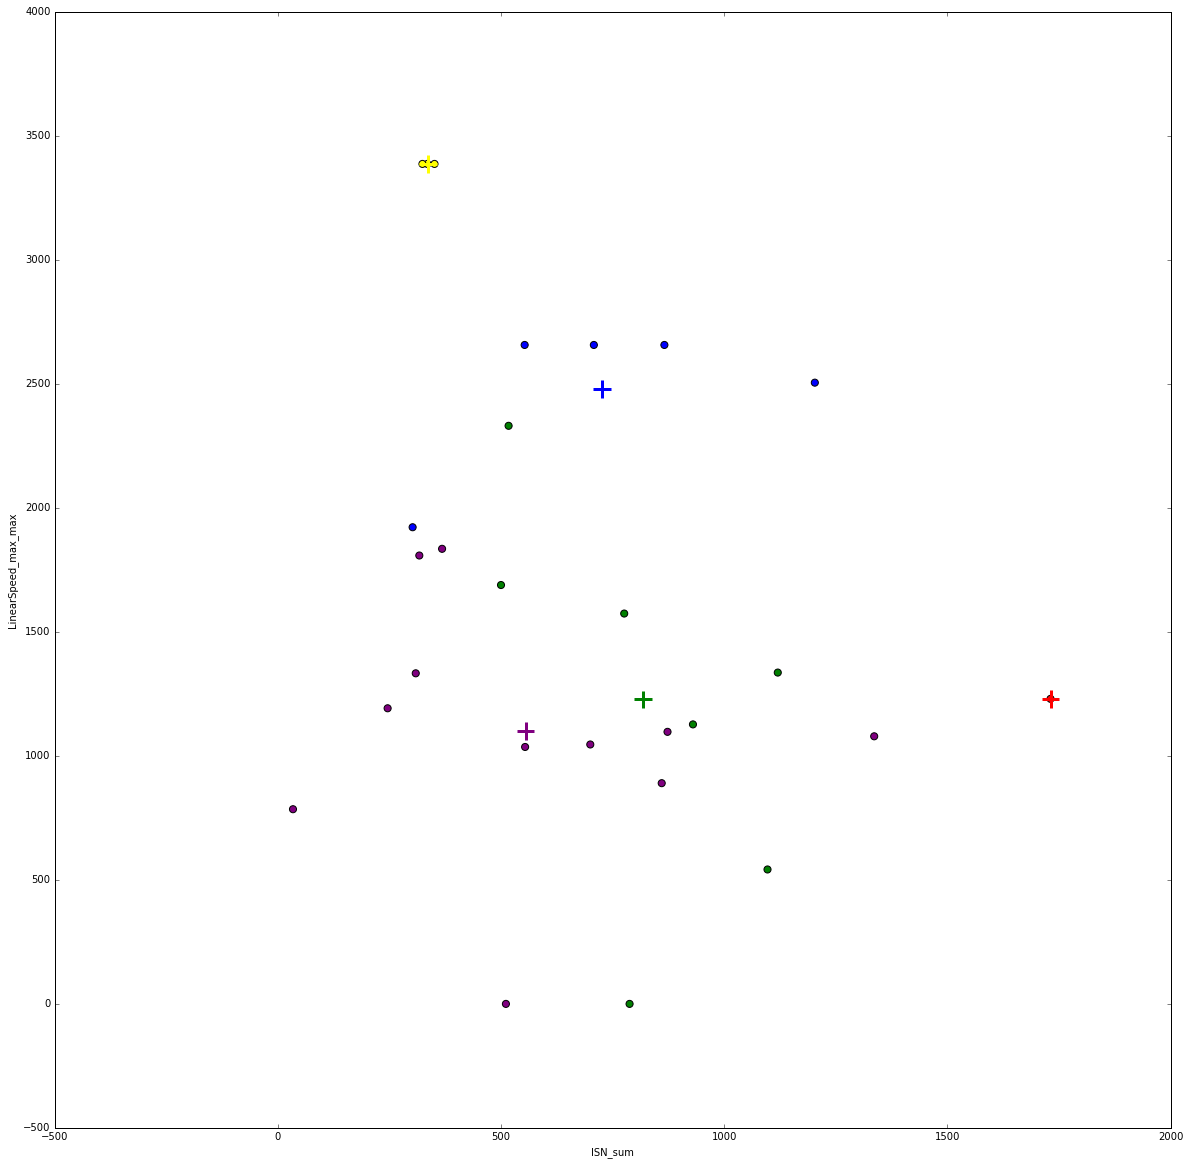

In [292]:
colors = np.array(['red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink', 'beige', 'brown', 'coral', 'darkgray', 'gold', 'olive'])
#pd.scatter_matrix(X, c=colors[results_filtered.cluster], figsize=(20,20), s=100)
centers = results_filtered.groupby('cluster').mean()

plt.figure(figsize=(20,20))
plt.scatter(results_filtered.ISN_sum, results_filtered.LinearSpeed_max_max, c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.ISN_sum, centers.LinearSpeed_max_max, linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
plt.xlabel('ISN_sum')
plt.ylabel('LinearSpeed_max_max')

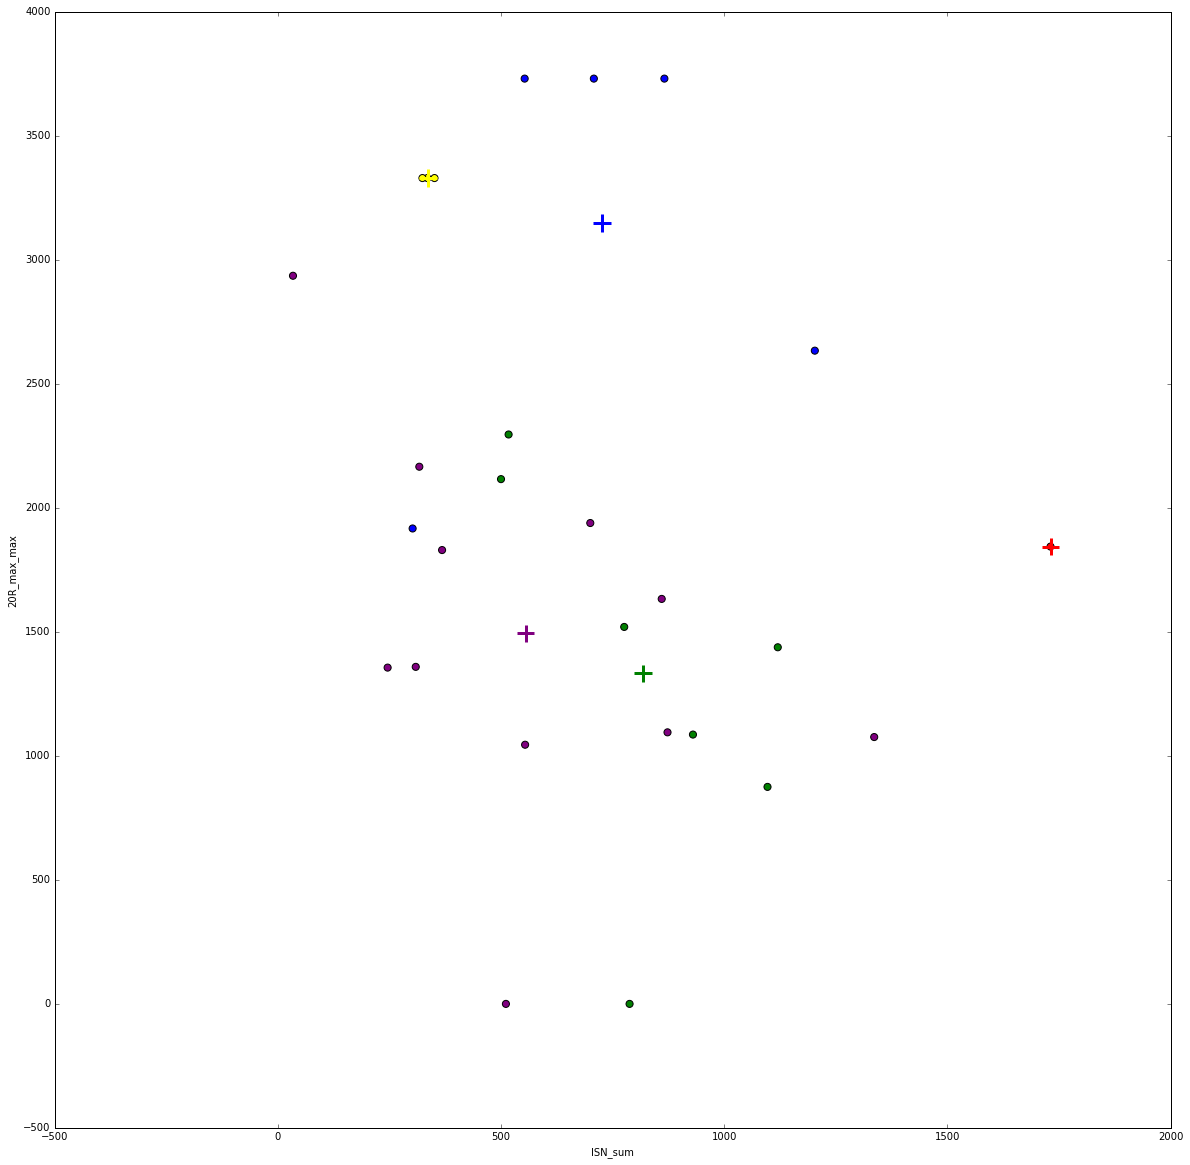

In [293]:
plt.figure(figsize=(20,20))
plt.scatter(results_filtered.ISN_sum, results_filtered['20R_max_max'], c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.ISN_sum, centers['20R_max_max'], linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
plt.xlabel('ISN_sum')
plt.ylabel('20R_max_max')

Evaluate the Model using Silhoutte Coefficient

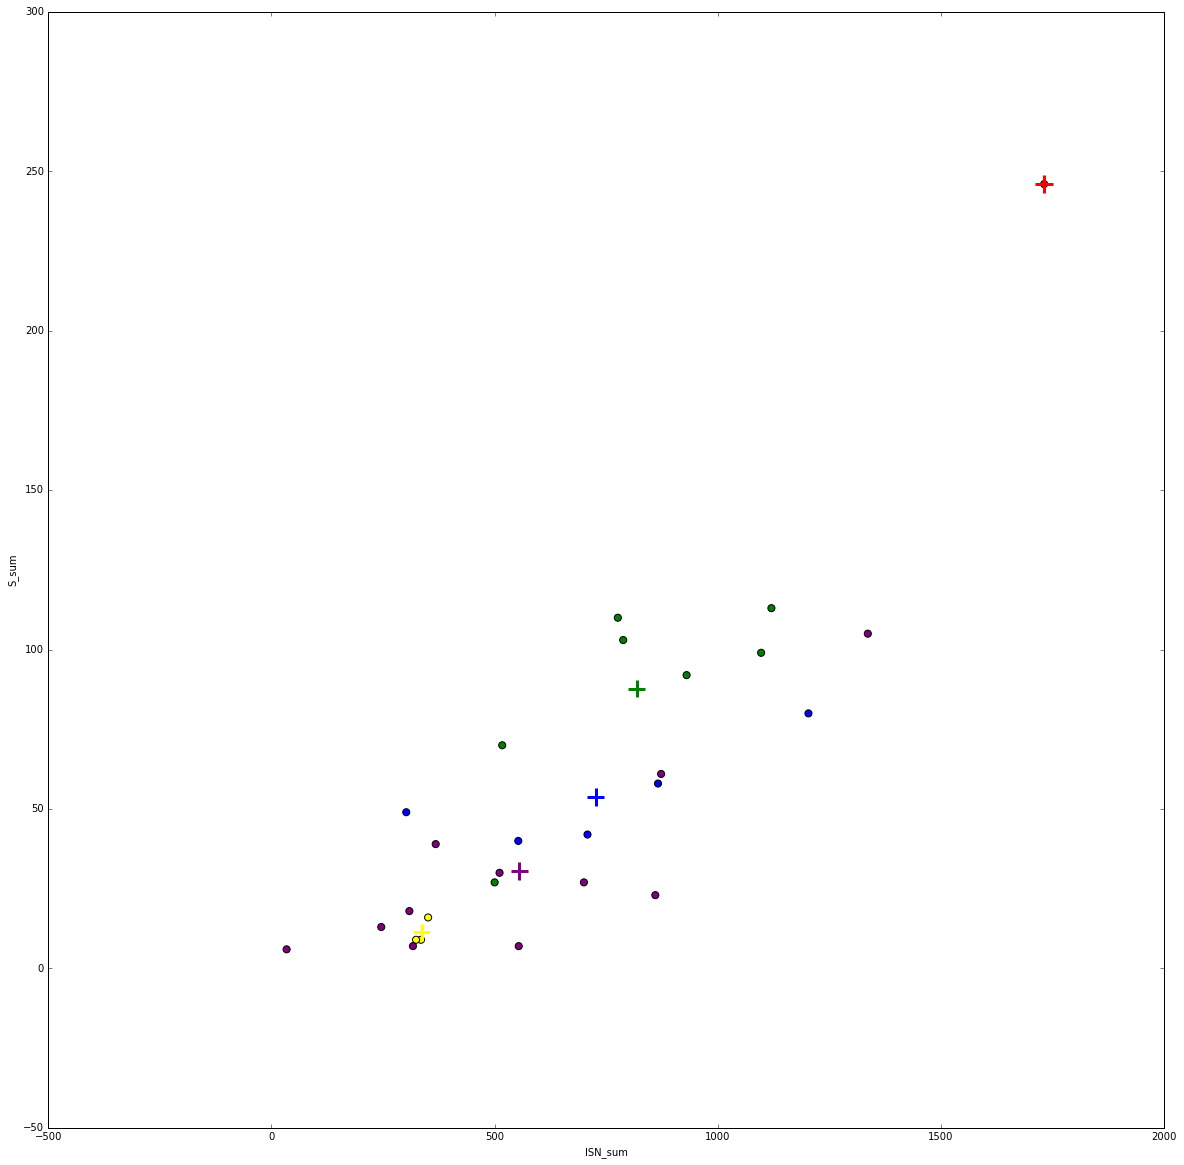

In [294]:
plt.figure(figsize=(20,20))
plt.scatter(results_filtered.ISN_sum, results_filtered['S_sum'], c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.ISN_sum, centers.S_sum, linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
plt.xlabel('ISN_sum')
plt.ylabel('S_sum')

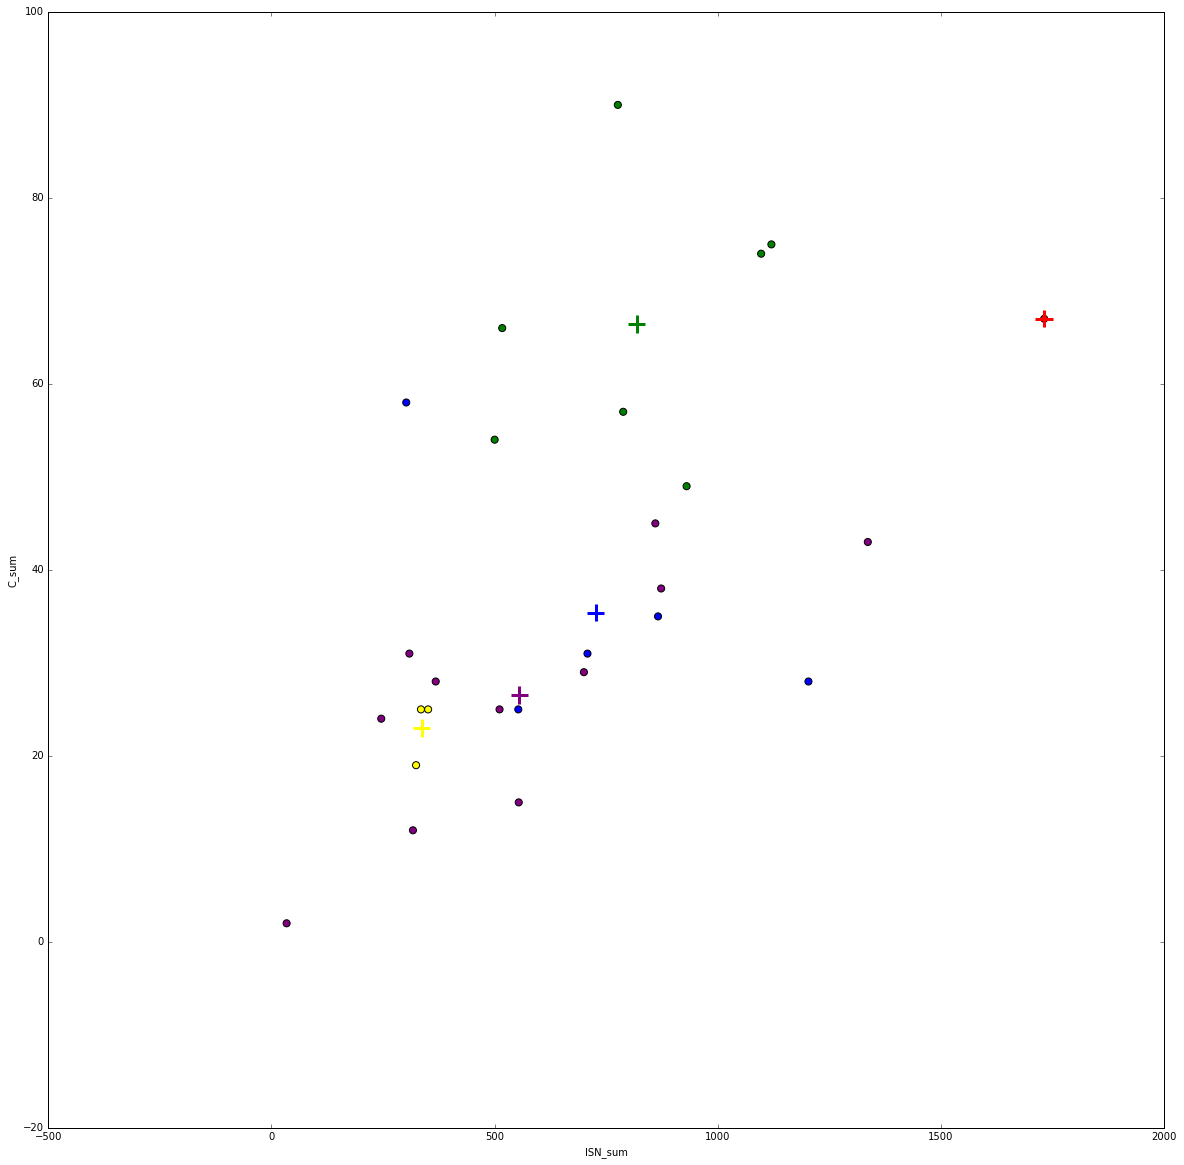

In [295]:
plt.figure(figsize=(20,20))
plt.scatter(results_filtered.ISN_sum, results_filtered['C_sum'], c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.ISN_sum, centers.C_sum, linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
plt.xlabel('ISN_sum')
plt.ylabel('C_sum')

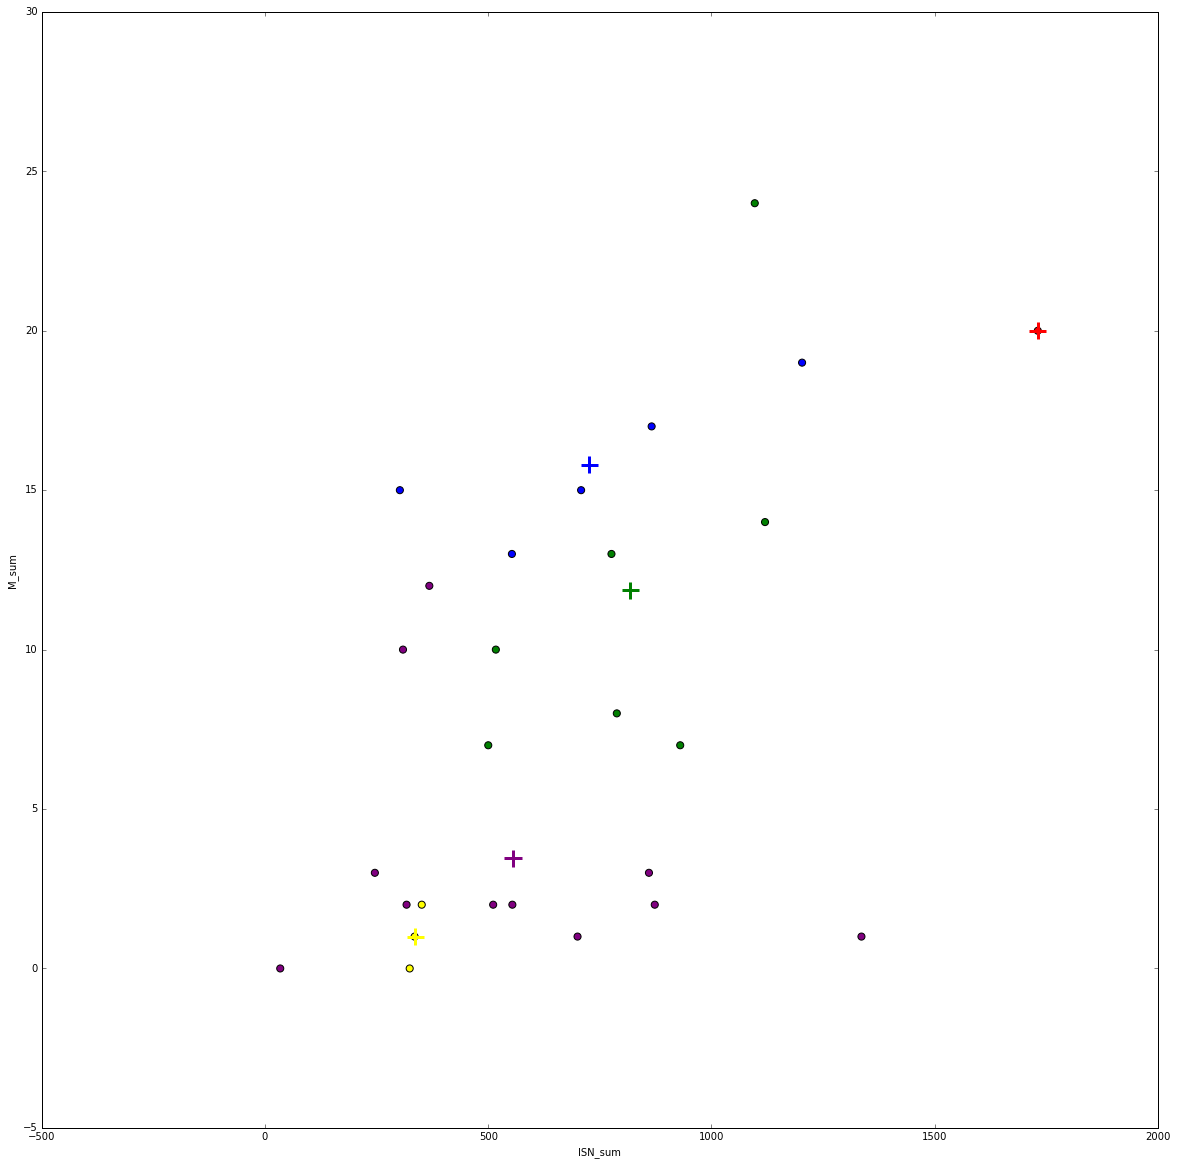

In [296]:
plt.figure(figsize=(20,20))
plt.scatter(results_filtered.ISN_sum, results_filtered['M_sum'], c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.ISN_sum, centers.M_sum, linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
plt.xlabel('ISN_sum')
plt.ylabel('M_sum')

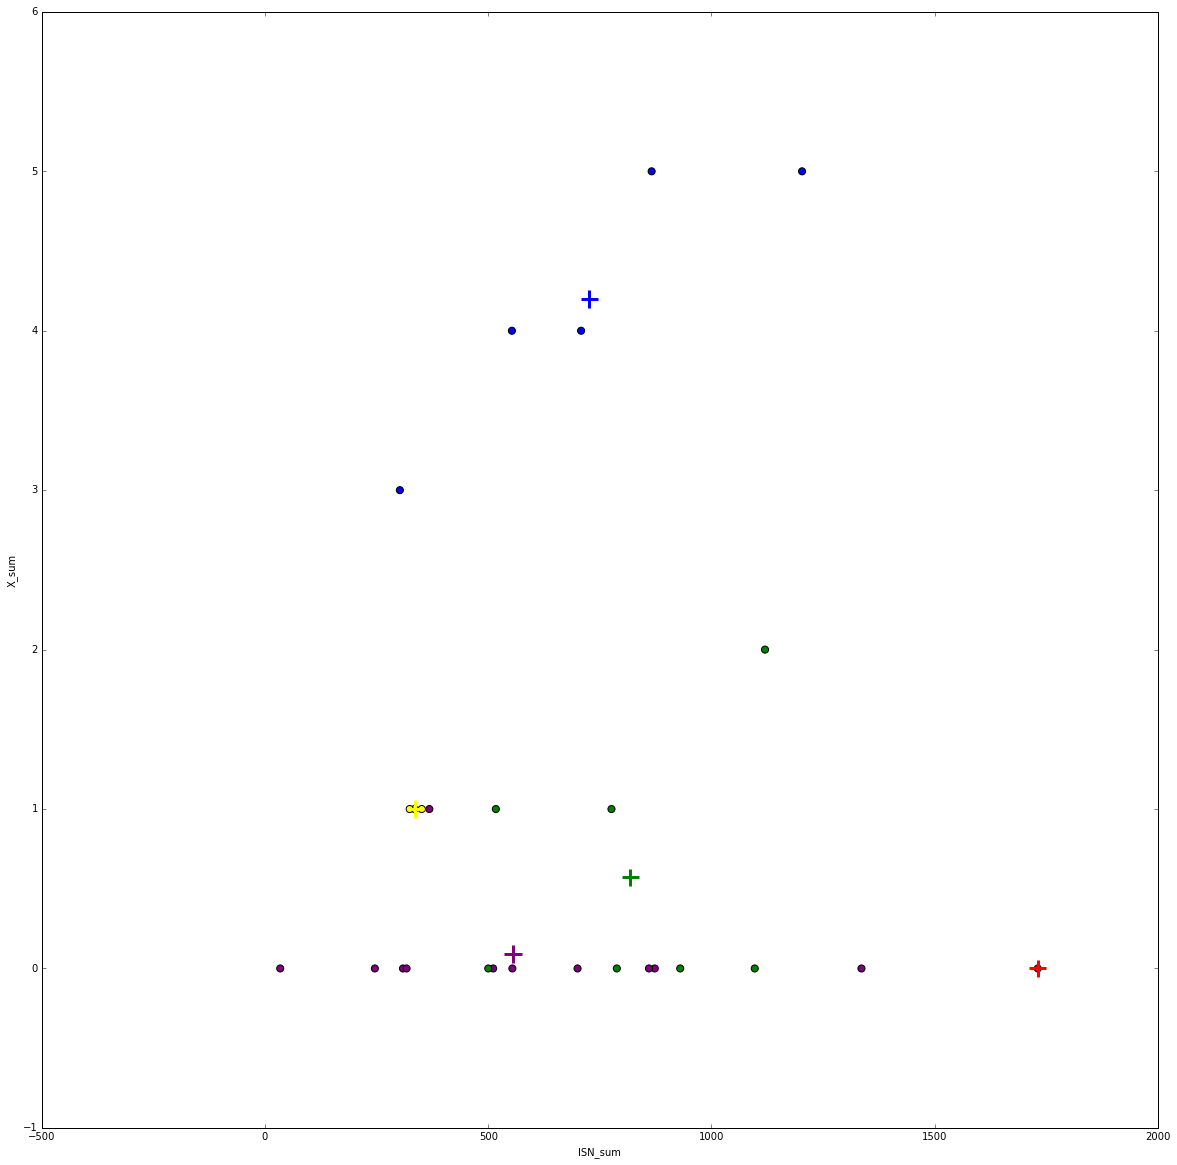

In [297]:
plt.figure(figsize=(20,20))
plt.scatter(results_filtered.ISN_sum, results_filtered['X_sum'], c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.ISN_sum, centers.X_sum, linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
plt.xlabel('ISN_sum')
plt.ylabel('X_sum')

In [298]:
# calculate SC 
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

0.46161695603915504

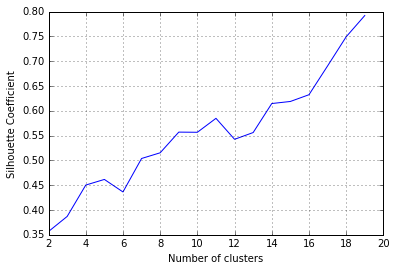

In [299]:
# calculate SC for K=2 through K=19
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

Cluster Selection was made by looking for the first local maximum on the graph above.

feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum']

SC = .346 with 5 clusters


feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'LinearSpeed_max_max']

SC = .370 with 6 clusters

feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 
                'LinearSpeed_max_max', '20R_max_max']
                
SC = .370 with 6 clusters

feature_cols = ['ISN_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum']

SC = .435 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum']

SC = .488 with 3 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum']

SC = .420 with 7 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum']

SC = .556 with 11 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt3_sum']

SC = .530 with 5 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum', 'Opt3_sum']

SC = .462 with 5 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'LinearSpeed_max_max']

SC = .441 with 7 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', '20R_max_max']

SC = .420 with 7 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-5']

SC = .360 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-4']

SC = .370 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-3']

SC = .370 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-2']

SC = .369 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-1']

SC = .369 with 3 clusters
